In [1]:
import pandas as pd
import os
import urllib
import pdb
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt

from keras import layers, models
from keras.applications import VGG16
from keras import Input
from keras.models import Model
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator

from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
color_label = {'빨강': 0, '주황': 1, '노랑': 2, '연두': 3, '초록': 4, 
               '청록': 5, '파랑': 6, '남색': 7, '보라': 8, '분홍': 9,
               '자주': 10,'갈색': 11, '회색': 12, '검정': 13, '하양': 14, '투명': 15}
#color_label

{'갈색': 11,
 '검정': 13,
 '남색': 7,
 '노랑': 2,
 '보라': 8,
 '분홍': 9,
 '빨강': 0,
 '연두': 3,
 '자주': 10,
 '주황': 1,
 '청록': 5,
 '초록': 4,
 '투명': 15,
 '파랑': 6,
 '하양': 14,
 '회색': 12}

In [3]:
"""
label_path = './label/label_color.xls'
xls = pd.read_excel(label_path)
df1 = pd.DataFrame(xls)
#print(df1)

df2 = df1[df1.columns[-1]].map(color_label)
df2 = pd.DataFrame(df2)
df1['color_front'] = df2['color_front']
#print(df1)

# cvs 파일로 만들기

type(df1)
df1.to_csv("./label/color.csv", mode='w')
"""

dataset = pd.read_csv("./label/color.csv")

In [4]:
datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator=datagen.flow_from_dataframe(dataframe=dataset,
                                            directory="./mask/",
                                            x_col="No",
                                            y_col="color_front",
                                            has_ext=False,
                                            subset="training",
                                            class_mode="categorical",
                                            target_size=(224,224),
                                            batch_size=32)

valid_generator=datagen.flow_from_dataframe(dataframe=dataset,
                                            directory="./mask/",
                                            x_col="No",
                                            y_col="color_front",
                                            has_ext=False,
                                            subset="validation",
                                            class_mode="categorical",
                                            target_size=(224,224),
                                            batch_size=32)

/usr/local/lib/python3.5/dist-packages/keras_preprocessing/image.py:2059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.df[x_col] = self.df[x_col].astype(str)


Found 16257 images belonging to 17 classes.
Found 4147 images belonging to 17 classes.


In [6]:
pre_trained_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
pre_trained_vgg.trainable = True
pre_trained_vgg.summary()
 
additional_model = models.Sequential()
additional_model.add(pre_trained_vgg)
additional_model.add(layers.Flatten())
#additional_model.add(layers.Dense(4096, activation='relu'))
#additional_model.add(layers.Dense(2048, activation='relu'))
additional_model.add(layers.Dense(1024, activation='relu'))
additional_model.add(layers.Dense(17, activation='softmax'))
 

additional_model.summary()
 

checkpoint = ModelCheckpoint(filepath='pretrained_VGG_weight.hdf5', 
            monitor='loss', 
            mode='min', 
            save_best_only=True)
 
additional_model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])


history = additional_model.fit_generator(train_generator, 
            steps_per_epoch=math.ceil(train_generator.n / train_generator.batch_size), 
            epochs=10, 
            validation_data=valid_generator, 
            validation_steps=math.ceil(valid_generator.n / valid_generator.batch_size), 
            callbacks=[checkpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

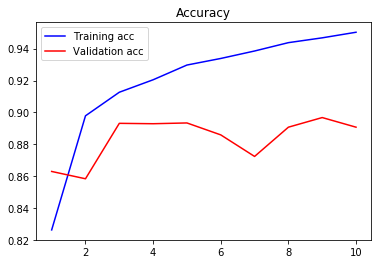

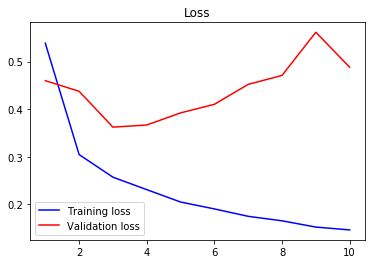

In [8]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show() 